# Алгоритм автоматической застройки участка

## Вводные

### Описание задания

Необходимо разработать алгоритм автоматического распределения территорий на участке с учётом заданных параметров. 

На **вход** подаются координаты участка в формате GeoJSON и ключевые градостроительные ограничения. 

На **выходе** – GeoJSON-файл с информацией о расположении объектов и изображение плана застройки.

### Входные данные
Программа должна принимать следующие параметры:
1. Границы участка – передаются в формате GeoJSON (FeatureCollection с Polygon).

2. Ограничения по плотности застройки – процент площади участка, допустимый для застройки.

3. Минимальное расстояние между объектами – например, 10 метров между зданиями.

4. Дополнительные ограничения – наличие дорог, лесов, водоемов, на которых нельзя строить (также передаются в GeoJSON).

### Задачи
1. Разделить участок на логические зоны (например, жилая застройка, парки, дороги).

2. Разместить объекты (здания, дороги, зеленые зоны) с учётом заданных ограничений, исключая застройку в запрещенных зонах (дороги, леса, водоемы).

3. Сформировать GeoJSON-файл с координатами размещённых объектов.

4. Сгенерировать изображение плана участка.

5. Различные варианты.

6. Задача формы.

7. Учет доступности общественного транспорта.

### Выходные данные
1. Файл GeoJSON с информацией об объектах на участке в формате:
```json
{
"type": "FeatureCollection",
"features": [
	{"type": "Feature", "properties": {"type": "residential"}, "geometry": {"type": "Polygon", "coordinates": [[...]]}},
	{"type": "Feature", "properties": {"type": "commercial"}, "geometry": {"type": "Polygon", "coordinates": [[...]]}},
	{"type": "Feature", "properties": {"type": "road"}, "geometry": {"type": "LineString", "coordinates": [[...]]}},
	{"type": "Feature", "properties": {"type": "park"}, "geometry": {"type": "Polygon", "coordinates": [[...]]}}
]
}
```
2. Изображение (.png или .jpg) с графическим представлением застройки участка.


# Предварительные размышления
4 зоны - резиденция, коммерция, дрога, парк

Задаются какие-то ограничения(дополнительные). 
+ пересечения
+ форма объектов 
+ количество.
+ объекты наверное должны быть соеденены дорогами.
+ процент плотности
+ минимальное расстояние
+ минимальная площадь

В общем и целом задача о рюкзаке.

### Общая структура
1. В дополнение к общему плану в сущность будет передаваться список объектов (тип-форма-количество)
+ Для дорог - только основные, соединяющие автоматом.
2. ...

# Реализация

In [ ]:
import geopandas as gpd
import pandas as pd
import shapely as sh
import numpy as np
import matplotlib.pyplot as plt

DF = gpd.read_file('data_test.geojson')
DF['restriction'] = DF['restriction'].astype(str)
DF.loc[DF['restriction'] == 'None', 'color'] = 'grey'
DF.loc[DF['restriction'] == 'no_build', 'color'] = 'red'
DF.plot(figsize=(10,10), edgecolor='black', facecolor=DF['color'])
DF

In [252]:
OBJECTS_DF = pd.DataFrame(
    {
        'name': ['residential', 'residential', 'commercial', 'park'],
        'shape': ['circle', 'rectangle', 'rectangle', 'rectangle'],
        'amount': [1, 1, 1, 1]
    }
)
OBJECTS_DF['name_shape'] = OBJECTS_DF['name'] + '_' + OBJECTS_DF['shape']
OBJECTS_DF

,name,shape,amount,name_shape
0,residential,circle,1,residential_circle
1,residential,rectangle,1,residential_rectangle
2,commercial,rectangle,1,commercial_rectangle
3,park,rectangle,1,park_rectangle


49.0

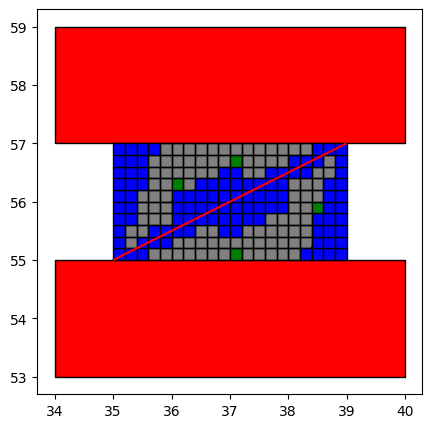

In [ ]:
class Cell:
    def __init__(self, xmin, ymin, xmax, ymax, building_zone, roads, i, j):
        self.polygon = sh.geometry.Polygon(
            [(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin), (xmin, ymin)]
        )
        self.status = None if self.polygon.equals(self.polygon.intersection(building_zone)) else False
        for road in roads:
            if road.intersects(self.polygon):
                self.status = False
                break
        self.i = i
        self.j = j
        self.center = self.polygon.centroid

    def __repr__(self):
        return f'{self.polygon}\nStatus inds: {self.status}\nGrid coords: {self.i}, {self.j}'
        
class Plan:
    def __init__(
            self,
            zones: gpd.GeoDataFrame,
            objects: pd.DataFrame,
            aviable_area_rate: float,
            minimal_distance: float
        ):
        self.zones = zones
        self.objects = objects
        self.aviable_area_rate = aviable_area_rate
        self.minimal_distance = minimal_distance
        self.number_of_objects = objects['amount'].sum()

        full_building_zone = sh.unary_union(
            self.zones.loc[self.zones['restriction'] == 'None', 'geometry']
        )

        self.building_zone = (
            full_building_zone
            .difference(
                sh.unary_union(
                    self.zones.loc[self.zones['restriction'] == 'no_build', 'geometry']
                )
            )
        )

        self.aviable_area = full_building_zone.area * self.aviable_area_rate
        if self.aviable_area > self.building_zone.area: self.remaining_area = self.building_zone.area
        else: self.remaining_area = self.aviable_area

        self.xmin, self.ymin, self.xmax, self.ymax = self.building_zone.bounds
        self.average_max_area = self.remaining_area / self.number_of_objects

    def make_grid(self):
        total_width = self.xmax - self.xmin
        total_height = self.ymax - self.ymin
        
        cell_shape = self.minimal_distance
        grid_width = int(np.ceil(total_width / cell_shape))
        grid_height = int(np.ceil(total_height / cell_shape))
        grid = np.full((grid_width, grid_height), None)

        grid_df = {'name': [], 'geometry': [], 'color': []}

        for i in range(grid_width):
            for j in range(grid_height):
                grid[i][j] = Cell(
                    self.xmin + cell_shape * i,
                    self.ymin + cell_shape * j,
                    self.xmin + cell_shape * (i + 1),
                    self.ymin + cell_shape * (j + 1),
                    self.building_zone,
                    self.zones.loc[self.zones['name'] == 'Дорога', 'geometry'],
                    i, j
                )
                grid_df['name'].append(f'{i}_{j}')
                grid_df['geometry'].append(grid[i][j].polygon)
                grid_df['color'].append("none" if grid[i][j].status == None else "blue")
        
        suggested_cells, validated_cells = [], []

        while True:
            base_point = grid[np.random.randint(0, grid_width)][np.random.randint(0, grid_height)]
            if base_point.status != False:
                suggested_cells.append(base_point)
                validated_cells.append(base_point)
                break

        while len(suggested_cells) > 0:
            suggested_idx = np.random.randint(len(suggested_cells))
            suggested_cell = suggested_cells[suggested_idx]
            found_flag = False
            for _ in range(1000):
                r = np.random.uniform(2*self.minimal_distance + np.sqrt(self.average_max_area),
                                      10 * self.minimal_distance + np.sqrt(self.average_max_area))
                phi = np.random.uniform(0, 2 * np.pi)

                x = suggested_cell.center.x + r * np.cos(phi)
                y = suggested_cell.center.y + r * np.sin(phi)

                grid_x = int((x - self.xmin) // cell_shape)
                grid_y = int((y - self.ymin) // cell_shape)
                if (
                        grid_x in range(0, grid_width) and 
                        grid_y in range(0, grid_height) and 
                        grid[grid_x][grid_y].status == None and
                        all(grid[grid_x][grid_y].polygon.distance(p.polygon) >= self.minimal_distance for p in validated_cells)
                    ):

                    grid[grid_x][grid_y].status = True
                    suggested_cells.append(grid[grid_x][grid_y])
                    grid[grid_x][grid_y].polygon = grid[grid_x][grid_y].polygon.buffer(self.minimal_distance, join_style="mitre")
                    validated_cells.append(grid[grid_x][grid_y])
                    found_flag = True
                    break
            if not found_flag: suggested_cells.pop(suggested_idx)
            if len(validated_cells) >= self.number_of_objects: break

        grid_df = gpd.GeoDataFrame(grid_df,  crs="EPSG:4326")
        all_df = pd.concat([DF, grid_df])
        for cell in validated_cells:
            all_df.loc[all_df['name'] == f'{cell.i}_{cell.j}', 'color'] = 'green'
        all_df.plot(figsize=(5,5), edgecolor='black', color=all_df['color'], aspect='equal')

        self.places_cells = validated_cells
        return validated_cells

    def create_buildings(self):

        def expand_circle():
            pass
        def expand_rectangle():
            pass
        
        cell_area = self.minimal_distance**2
        n_of_aviable_cels = self.remaining_area // cell_area

        grid_df = {
            'name': [111, 112, 113, 114], 
            'geometry': [vc.polygon for vc in self.places_cells], 
            'color': ['green','green','green','green']}
        grid_df = gpd.GeoDataFrame(grid_df,  crs="EPSG:4326")
        all_df = pd.concat([DF, grid_df])
        all_df.plot(figsize=(5,5), edgecolor='black', color=all_df['color'], aspect='equal')
        return n_of_aviable_cels

p = Plan(
    DF, OBJECTS_DF, 0.2, 0.2
)
p.make_grid()
p.create_buildings()